In [125]:
import pandas as pd
import requests
import datetime as dt
import csv
import numpy as np
import matplotlib.pyplot as plt
import psycopg2 as ps
import re

In [126]:
DB_NAME = 'iac_task'
DB_USER = 'postgres'
DB_PASS = 'password'
DB_HOST = 'localhost'
DB_PORT = '5432'

In [127]:
beg_day = dt.date.today()
end_day = beg_day + dt.timedelta(days=7)

print(beg_day)
print(end_day)

2023-09-20
2023-09-27


In [128]:
i = 1
has_later = False
end_cycle = False

final_df = pd.DataFrame()

while (True):
    tables = pd.read_html(f'https://rosseti-lenenergo.ru/planned_work/?PAGEN_1={i}')
    df = tables[1] # искомая таблица - вторая на странице
    
    for j in range(len(df.index)):
        date_object = dt.datetime.strptime(df.iloc[j][4], '%d-%m-%Y').date()
        if date_object > end_day:
            has_later = True
            later_index = j
        if date_object < beg_day:
            end_cycle = True
            earlier_index = j
            break

    if has_later:
        df.drop(df.index[:later_index+1], inplace=True)
    if end_cycle:
        df.drop(df.index[later_index:], inplace=True)
        
    
    final_df = df if i == 1 else pd.concat([final_df, df], ignore_index=True)
    
    i += 1
    has_later = False

    if end_cycle:
        break

In [131]:
final_df.dropna(subset=[('Улица', 'Улица')], inplace=True)
final_df = final_df[final_df[('Регион РФ(область, край, город фед. значения, округ)', 'Регион РФ(область, край, город фед. значения, округ)')] != 'Ленинградская область']
print(len(final_df.index))
final_df.head(50)

80


Регион РФ(область, край, город фед. значения, округ)  \
    Регион РФ(область, край, город фед. значения, округ)   
0                                      Санкт-Петербург     
2                                      Санкт-Петербург     
3                                      Санкт-Петербург     
6                                      Санкт-Петербург     
12                                     Санкт-Петербург     
13                                     Санкт-Петербург     
14                                     Санкт-Петербург     
15                                     Санкт-Петербург     
16                                     Санкт-Петербург     
17                                     Санкт-Петербург     
19                                     Санкт-Петербург     
20                                     Санкт-Петербург     
21                                     Санкт-Петербург     
22                                     Санкт-Петербург     
24                                     Санкт-Петербург     
27                                     Санкт-Петербург     
30                                     Санкт-Петербург     
31                                     Санкт-Петербург     
32                                     Санкт-Петербург     
34                                     Санкт-Петербург     
35                                     Санкт-Петербург     
36                                     Санкт-Петербург     
39                                     Санкт-Петербург     
40                                     Санкт-Петербург     
43                                     Санкт-Петербург     
47                                     Санкт-Петербург     
48                                     Санкт-Петербург     
49                                     Санкт-Петербург     
51                                     Санкт-Петербург     
54                                     Санкт-Петербург     
55                                     Санкт-Петербург     
56                                     Санкт-Петербург     
57                                     Санкт-Петербург     
58                                     Санкт-Петербург     
59                                     Санкт-Петербург     
65                                     Санкт-Петербург     
68                                     Санкт-Петербург     
70                                     Санкт-Петербург     
71                                     Санкт-Петербург     
72                                     Санкт-Петербург     
74                                     Санкт-Петербург     
85                                     Санкт-Петербург     
98                                     Санкт-Петербург     
108                                    Санкт-Петербург     
110                                    Санкт-Петербург     
112                                    Санкт-Петербург     
113                                    Санкт-Петербург     
114                                    Санкт-Петербург     
115                                    Санкт-Петербург     
116                                    Санкт-Петербург     

      Административный район               Населённый пункт  \
      Административный район               Населённый пункт   
0          Фрунзенский район             г. Санкт-Петербург   
2              Невский район                Санкт-Петербург   
3            Курортный район                     п.Комарово   
6            Курортный район                    п.Лисий Нос   
12             Невский район                Санкт-Петербург   
13         Фрунзенский район             г. Санкт-Петербург   
14         Фрунзенский район             г. Санкт-Петербург   
15    Выборгский район (СПб)                Санкт-Петербург   
16    Приморский район (СПб)                Санкт-Петербург   
17    Василеостровский район                Санкт-Петербург   
19           Курортный район                  г.Зеленогорск   
20           Курортный район                  г.Зеленогорск   
2

916 points


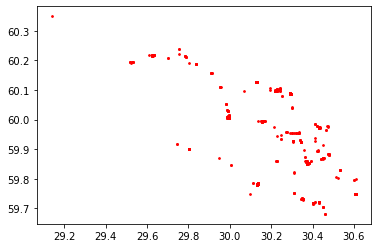

In [158]:
# for CSV

with open('iac.csv', 'w') as f:
    header = ['building_id', 'longitude', 'latitude', 'district_id']
    writer = csv.writer(f)
    writer.writerow(header)
    street = ''
    house = ''
    corp = ''
    same_house_i = -1
    num_points = 0
    for j in range(len(final_df.index)):
        ls = re.split(r'[,;]', final_df.iloc[j][3])
        for i in range(len(ls)):
            try:
                if ls[i][0] == ' ':
                    ls[i] = ls[i][1:]
            except:
                continue
        
        for i in range(len(ls)):
            if len(ls[i]) > 0 and same_house_i != i:
                ls[i] = ls[i].replace('Санкт-Петербург', '')
                try:
                    if ls[i][0] == 'д' or ls[i][0].isdigit():
                        house = ls[i]
                        if i != len(ls) - 1 and ls[i+1][0] == 'к':
                            corp = ls[i+1]
                            same_house_i = i + 1
                        else:
                            corp = ''
                    elif ls[i][0] == 'к':
                        corp = ls[i]
                    else:
                        street = ls[i]
                        house = ''
                        corp = ''
                except:
                    continue
            
            if house != '':
                api_url = f"https://geocode.gate.petersburg.ru/parse/free?street='{street + ' ' + house + ' ' + corp}'"
                response = requests.get(api_url)
                if response.status_code == 200:
                    data = response.json()
                    if 'Building_ID' in data:
                        plt.scatter(np.array([data['Longitude']]), np.array([data['Latitude']]), c='red', s=3.0)
                        num_points += 1
                        row = [data['Building_ID'], data['Longitude'], data['Latitude'], data['District_ID']]
                        writer.writerow(row)

print(f'{num_points} points')
plt.show()

916 points


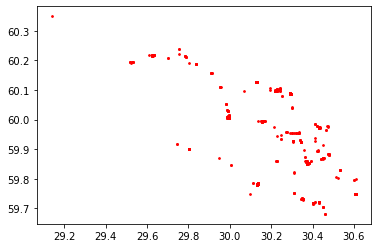

In [160]:
# for database

conn = ps.connect(database=DB_NAME,
                  user=DB_USER,
                  password=DB_PASS,
                  host=DB_HOST,
                  port=DB_PORT)

cur = conn.cursor()

cur.execute("""CREATE TABLE IF NOT EXISTS info 
            (building_id INT, 
             longitude FLOAT, 
             latitude FLOAT, 
             district_id INT)""")

conn.commit()

street = ''
house = ''
corp = ''
same_house_i = -1
num_points = 0
for j in range(len(final_df.index)):
    ls = re.split(r'[,;]', final_df.iloc[j][3])
    for i in range(len(ls)):
        try:
            if ls[i][0] == ' ':
                ls[i] = ls[i][1:]
        except:
            continue

    for i in range(len(ls)):
        if len(ls[i]) > 0 and same_house_i != i:
            ls[i] = ls[i].replace('Санкт-Петербург', '')
            try:
                if ls[i][0] == 'д' or ls[i][0].isdigit():
                    house = ls[i]
                    if i != len(ls) - 1 and ls[i+1][0] == 'к':
                        corp = ls[i+1]
                        same_house_i = i + 1
                    else:
                        corp = ''
                elif ls[i][0] == 'к':
                    corp = ls[i]
                else:
                    street = ls[i]
                    house = ''
                    corp = ''
            except:
                continue

        if house != '':
            api_url = f"https://geocode.gate.petersburg.ru/parse/free?street='{street + ' ' + house + ' ' + corp}'"
            response = requests.get(api_url)
            if response.status_code == 200:
                data = response.json()
                if 'Building_ID' in data:
                    plt.scatter(np.array([data['Longitude']]), np.array([data['Latitude']]), c='red', s=3.0)
                    num_points += 1
                    cur.execute(f"""INSERT INTO info VALUES 
                                ({data['Building_ID']}, 
                                 {data['Longitude']}, 
                                 {data['Latitude']},
                                 {data['District_ID']})""")
                    conn.commit()

print(f'{num_points} points')
plt.show()